In [4]:
import pandas as pd
import numpy as np
import nltk
nltk.download('wordnet')
import re
from bs4 import BeautifulSoup
# import csv
import matplotlib.pyplot as plt
# import contractions
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\monkeydc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
# !pip install bs4 
# !pip install matplotlib
# Dataset: https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Beauty_v1_00.tsv.gz

## Read Data

In [6]:
# Extract Column Names
columns_names = pd.read_csv('./amazon_reviews_us_Office_Products_v1_00.tsv', sep='\t', nrows=0)
print(columns_names)
raw_data = pd.read_csv('./amazon_reviews_us_Office_Products_v1_00.tsv', sep='\t',quoting=3)

Empty DataFrame
Columns: [marketplace, customer_id, review_id, product_id, product_parent, product_title, product_category, star_rating, helpful_votes, total_votes, vine, verified_purchase, review_headline, review_body, review_date]
Index: []


## Keep Reviews and Ratings

In [7]:
# Extract data
columns = ['review_body', 'star_rating']
raw_review_rating =  raw_data[columns]
print("three sample reviews:")
print(raw_review_rating.sample(n=3))

three sample reviews:
                                               review_body  star_rating
1686281  I received my two pack of cartridges yesterday...            1
2431071  This print has all the good features but can n...            1
762084   My daughter was required to purchase this for ...            5


In [8]:
star_rating_counts = raw_review_rating['star_rating'].value_counts()
labels = star_rating_counts.index
sizes = star_rating_counts.values
print(labels)
print(sizes)

Int64Index([5, 4, 1, 3, 2], dtype='int64')
[1584192  418694  307234  193818  138496]


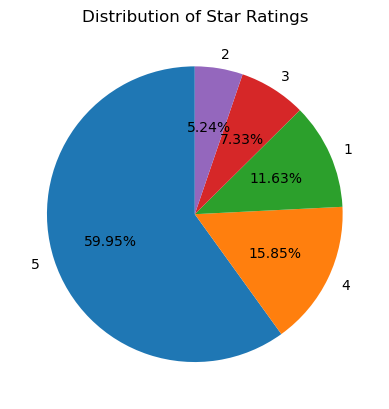

In [9]:
plt.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=90)
plt.title('Distribution of Star Ratings')
plt.show()

 ## We form three classes and select 20000 reviews randomly from each class.



In [10]:
for index in range(len(raw_review_rating)):
    if raw_review_rating.at[index, 'star_rating'] > 3:
        raw_review_rating.at[index, 'star_rating'] = 1
    elif raw_review_rating.at[index, 'star_rating'] == 3:
        raw_review_rating.at[index, 'star_rating'] = 3
    else:
        raw_review_rating.at[index, 'star_rating'] = 0

Text(0, 0.5, 'Frequency')

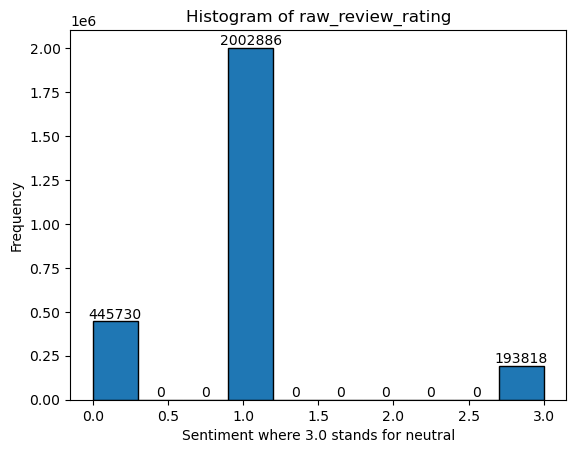

In [11]:
ax = raw_review_rating['star_rating'].plot(kind='hist', bins=10, edgecolor='black')
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.title('Histogram of raw_review_rating')
plt.xlabel('Sentiment where 3.0 stands for neutral')
plt.ylabel('Frequency')

In [12]:
print("The number of negative reviews is 445730")
print("The number of positive reviews is 2002886")
print("The number of neutral reviews is 193818")

The number of negative reviews is 445730
The number of positive reviews is 2002886
The number of neutral reviews is 193818


In [13]:
values_to_stratify = [0,1]

def stratified_sample(group, n=100000):
    return group.sample(n=n, random_state=1)

sampled_data = raw_review_rating[raw_review_rating['star_rating'].isin(values_to_stratify)].groupby('star_rating', group_keys=False).apply(stratified_sample)

Text(0, 0.5, 'Frequency')

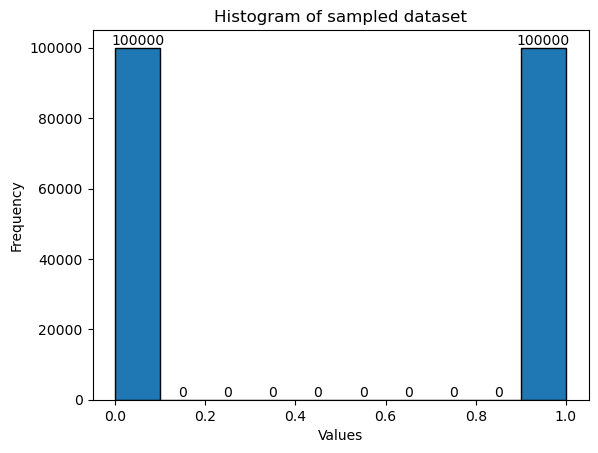

In [14]:
ax = sampled_data['star_rating'].plot(kind='hist', bins=10, edgecolor='black')
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.title('Histogram of sampled dataset')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Data Cleaning



# Pre-processing

In [15]:
sampled_data['review_body'] = sampled_data['review_body'].fillna('') # NaN processing
# sampled_data['review_headline'] = sampled_data['review_headline'].fillna('') # NaN processing
sampled_data.reset_index(drop=True, inplace=True) # rew index

In [16]:
# convert the all reviews into the lower case
print("three sample reviews:")
print(raw_review_rating.sample(n=3))
before_clean = sampled_data['review_body'].apply(len).mean()
print("before data cleaning, the avg length is ", before_clean)
print(f"avg length of reviews before lowering case :{sampled_data['review_body'].apply(len).mean()}")
sampled_data['review_body'] = sampled_data['review_body'].str.lower()
# sampled_data['review_headline'] = sampled_data['review_headline'].str.lower()
print(f"avg length of reviews after lowering case :{sampled_data['review_body'].apply(len).mean()}")

three sample reviews:
                                               review_body  star_rating
806855                     They worked on our phones fine.            1
2204239  I first purchased these coasters in New York a...            1
719874   My original Uniden BT-446 batteries were each ...            0
before data cleaning, the avg length is  317.956425
avg length of reviews before lowering case :317.956425
avg length of reviews after lowering case :317.956425


In [17]:
print(f"avg length of reviews before removing html :{sampled_data['review_body'].apply(len).mean()}")
sampled_data['review_body'] = sampled_data['review_body'].apply(lambda x: re.sub(r'http\S+', '', BeautifulSoup(x, 'html.parser').get_text()))
# sampled_data['review_headline'] = sampled_data['review_headline'].apply(lambda x: re.sub(r'http\S+', '', BeautifulSoup(x, 'html.parser').get_text()))
print(f"avg length of reviews after removing html :{sampled_data['review_body'].apply(len).mean()}")

avg length of reviews before removing html :317.956425


C:\Users\monkeydc\.conda\envs\561\lib\site-packages\ipykernel_launcher.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  
C:\Users\monkeydc\.conda\envs\561\lib\site-packages\ipykernel_launcher.py:2: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  


avg length of reviews after removing html :313.962965


In [18]:
# remove non-alphabetical characters
print(f"avg length of reviews before removing non-alphabetical characters :{sampled_data['review_body'].apply(len).mean()}")
def remove_non_alphabetical(text):
    return re.sub(r'[^a-zA-Z\s]', '', text)

sampled_data['review_body'] = sampled_data['review_body'].apply(remove_non_alphabetical)
# sampled_data['review_body'] = sampled_data['review_body'].apply(lambda x: ' '.join(filter(lambda word: re.findall(r'\b[a-zA-Z]+\b', word), x.split())))
# sampled_data['review_headline'] = sampled_data['review_headline'].apply(lambda x: ' '.join(filter(lambda word: re.findall(r'\b[a-zA-Z]+\b', word), x.split())))
print(f"avg length of reviews after removing non-alphabetical characters :{sampled_data['review_body'].apply(len).mean()}")

avg length of reviews before removing non-alphabetical characters :313.962965
avg length of reviews after removing non-alphabetical characters :302.50305


In [19]:
# remove extra spaces
print(f"avg length of reviews before removing extra spaces :{sampled_data['review_body'].apply(len).mean()}")
sampled_data['review_body'] = sampled_data['review_body'].apply(lambda x: ' '.join(x.split()))
# sampled_data['review_headline'] = sampled_data['review_headline'].apply(lambda x: ' '.join(x.split()))
print(f"avg length of reviews after removing extra spaces :{sampled_data['review_body'].apply(len).mean()}")

avg length of reviews before removing extra spaces :302.50305
avg length of reviews after removing extra spaces :300.1004


In [20]:
# perform contractions on the reviews
# contractions
print(f"avg length of reviews before performing contractions :{sampled_data['review_body'].apply(len).mean()}")
contraction_dict = contraction_dict = {
    "don't": "do not",
    "doesn't": "does not",
    "didn't": "did not",
    "can't": "cannot",
    "won't": "will not",
    "isn't": "is not",
    "haven't": "have not",
    "hasn't": "has not",
    "hadn't": "had not",
    "you're": "you are",
    "you've": "you have",
    "you'll": "you will",
    "when's": "when is",
    "let's": "let us",
    "'cause": "because",
    "shouldn't": "should not",
    "wouldn't": "would not",
    "couldn't": "could not",
    "wasn't": "was not",
    "weren't": "were not",
    "I'm": "I am",
    "I've": "I have",
    "I'll": "I will",
    "it's": "it is",
    "that's": "that is",
    "who's": "who is",
    "what's": "what is",
    "where's": "where is",
    "we're": "we are",
    "we've": "we have",
    "we'll": "we will",
    "they're": "they are",
    "they've": "they have",
    "they'll": "they will",
    "she's": "she is",
    "he's": "he is",
    "how's": "how is",
    "you'd": "you would",
    "we'd": "we would",
    "they'd": "they would",
}
sampled_data['review_body'] = sampled_data['review_body'].replace(contraction_dict, regex=True)
# sampled_data['review_headline'] = sampled_data['review_headline'].replace(contraction_dict, regex=True)
# sampled_data['review_body'] = sampled_data['review_body'].apply(lambda x: contractions.fix(x))
# sampled_data['review_headline'] = sampled_data['review_headline'].apply(lambda x: contractions.fix(x))
print(f"avg length of reviews after performing contractions :{sampled_data['review_body'].apply(len).mean()}")

after_clean = sampled_data['review_body'].apply(len).mean()
print("after data cleaning, the avg length is ", after_clean)

avg length of reviews before performing contractions :300.1004
avg length of reviews after performing contractions :300.1004
after data cleaning, the avg length is  300.1004


In [21]:
print("three sample reviews:")
print(raw_review_rating.sample(n=3))

three sample reviews:
                                               review_body  star_rating
294887   They were great and lasted as long as they sai...            1
1983191  I bought this because I have my first desk job...            1
16810    This was a repeat order. I continue to order t...            1


## remove the stop words 

In [22]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
before_pre = sampled_data['review_body'].apply(len).mean()
print("before Preprocessing, the avg length is ", before_pre)
def remove_stop_words(text):
    words = text.split(" ")
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)
print(f"avg length of reviews before removing the stop words :{sampled_data['review_body'].apply(len).mean()}")
sampled_data['review_body'] = sampled_data['review_body'].apply(remove_stop_words)
# sampled_data['review_headline'] = sampled_data['review_headline'].apply(remove_stop_words)
print(f"avg length of reviews after removing the stop words :{sampled_data['review_body'].apply(len).mean()}")

before Preprocessing, the avg length is  300.1004
avg length of reviews before removing the stop words :300.1004


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\monkeydc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


avg length of reviews after removing the stop words :194.12593


## perform lemmatization  

In [23]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
nltk.download('omw-1.4') # I have to download this dataset
print(f"avg length of reviews before performing lemmatization :{sampled_data['review_body'].apply(len).mean()}")
sampled_data['review_body'] = sampled_data['review_body'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
# sampled_data['review_headline'] = sampled_data['review_headline'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
print(f"avg length of reviews after performing lemmatization :{sampled_data['review_body'].apply(len).mean()}")

avg length of reviews before performing lemmatization :194.12593


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\monkeydc\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


avg length of reviews after performing lemmatization :190.984275


In [62]:
after_clean = sampled_data['review_body'].apply(len).mean()
print("after  Preprocessing, the avg length is ", after_clean)
print("three sample reviews:")
print(raw_review_rating.sample(n=3))

after  Preprocessing, the avg length is  190.984275
three sample reviews:
                                               review_body  star_rating
1612730  The scanner is really quite remarkable. The qu...            3
1254962  Nice refillable highlighter. Now trying the ey...            1
1195507                                        works great            1


# TF-IDF Feature Extraction

In [ ]:
# body
shuffled_dataset = shuffle(sampled_data, random_state=42)
tfidf_vectorizer_body = TfidfVectorizer()
tfidf_matrix_body = tfidf_vectorizer_body.fit_transform(shuffled_dataset['review_body'])
# merged_dataset = pd.concat([pd.DataFrame.sparse.from_spmatrix(tfidf_matrix_body), sampled_data['star_rating']],axis=1)

In [ ]:
# shuffled_merged_dataset = shuffle(merged_dataset, random_state=42)
Label= shuffled_dataset['star_rating']
# Features = shuffled_merged_dataset.drop('star_rating', axis=1)
Features = tfidf_matrix_body

In [22]:
feature_train, feature_test, label_train, label_test = train_test_split(Features, Label, test_size=0.2, random_state=42,stratify=Label)

# Perceptron

In [38]:
from sklearn.model_selection import GridSearchCV
perceptron = Perceptron(random_state=1122)
perceptron.fit(feature_train, label_train)

# param_grid = {
#     'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
#     'max_iter': [10, 50, 100, 200, 500],
#     'penalty': ['l2', 'l1', 'elasticnet', None]
# }
# perceptron = Perceptron(random_state=42)
# grid_search = GridSearchCV(perceptron, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
# grid_search.fit(feature_train, label_train)
# print("Best Parameters:", grid_search.best_params_)
# perceptron = grid_search.best_estimator_

label_pred_train = perceptron.predict(feature_train)
t_accuracy = accuracy_score(label_train, label_pred_train)
t_precision = precision_score(label_train, label_pred_train)
t_recall = recall_score(label_train, label_pred_train)
t_f1 = f1_score(label_train, label_pred_train)
print(f"train accuracy for Perceptron：{t_accuracy}")
print(f"train precision for Perceptron：{t_precision}")
print(f"train recall for Perceptron：{t_recall}")
print(f"train f1_score for Perceptron：{t_f1}")

label_pred = perceptron.predict(feature_test)
accuracy = accuracy_score(label_test, label_pred)
precision = precision_score(label_test, label_pred)
recall = recall_score(label_test, label_pred)
f1 = f1_score(label_test, label_pred)
print(f"test accuracy for Perceptron：{accuracy}")
print(f"test precision for Perceptron：{precision}")
print(f"test recall for Perceptron：{recall}")
print(f"test f1_score for Perceptron：{f1}")

train accuracy for Perceptron：0.90711875
train precision for Perceptron：0.9121521582324134
train recall for Perceptron：0.9010125
train f1_score for Perceptron：0.9065481093929808
test accuracy for Perceptron：0.855925
test precision for Perceptron：0.8617675458657316
test recall for Perceptron：0.84785
test f1_score for Perceptron：0.8547521233964261


# SVM

In [56]:
# feature_train, feature_test, label_train, label_test = train_test_split(Features, Label, test_size=0.2, random_state=42

svm_model = LinearSVC(random_state=1122, max_iter = 1000, loss = "hinge")
svm_model.fit(feature_train, label_train)

label_pred_train = perceptron.predict(feature_train)
t_accuracy = accuracy_score(label_train, label_pred_train)
t_precision = precision_score(label_train, label_pred_train)
t_recall = recall_score(label_train, label_pred_train)
t_f1 = f1_score(label_train, label_pred_train)
print(f"train accuracy for SVM：{t_accuracy}")
print(f"train precision for SVM：{t_precision}")
print(f"train recall for SVM：{t_recall}")
print(f"train f1_score for SVM：{t_f1}")

label_pred = svm_model.predict(feature_test)
accuracy = accuracy_score(label_test, label_pred)
precision = precision_score(label_test, label_pred)
recall = recall_score(label_test, label_pred)
f1 = f1_score(label_test, label_pred)
print(f"test accuracy for SVM：{accuracy}")
print(f"test precision for SVM：{precision}")
print(f"test recall for SVM：{recall}")
print(f"test f1_score for SVM：{f1}")

train accuracy for SVM：0.90711875
train precision for SVM：0.9121521582324134
train recall for SVM：0.9010125
train f1_score for SVM：0.9065481093929808
test accuracy for SVM：0.895625
test precision for SVM：0.8984339594138677
test recall for SVM：0.8921
test f1_score for SVM：0.8952557766125592


In [57]:
from sklearn.svm import SVC
svm_model = SVC()
svm_model.fit(feature_train, label_train)

label_pred_train = perceptron.predict(feature_train)
t_accuracy = accuracy_score(label_train, label_pred_train)
t_precision = precision_score(label_train, label_pred_train)
t_recall = recall_score(label_train, label_pred_train)
t_f1 = f1_score(label_train, label_pred_train)
print(f"train accuracy for SVM：{t_accuracy}")
print(f"train precision for SVM：{t_precision}")
print(f"train recall for SVM：{t_recall}")
print(f"train f1_score for SVM：{t_f1}")

label_pred = svm_model.predict(feature_test)
accuracy = accuracy_score(label_test, label_pred)
precision = precision_score(label_test, label_pred)
recall = recall_score(label_test, label_pred)
f1 = f1_score(label_test, label_pred)
print(f"test accuracy for SVM：{accuracy}")
print(f"test precision for SVM：{precision}")
print(f"test recall for SVM：{recall}")
print(f"test f1_score for SVM：{f1}")

train accuracy for SVM：0.90711875
train precision for SVM：0.9121521582324134
train recall for SVM：0.9010125
train f1_score for SVM：0.9065481093929808
test accuracy for SVM：0.9035
test precision for SVM：0.9082355321732092
test recall for SVM：0.8977
test f1_score for SVM：0.9029370348018507


# Logistic Regression

In [40]:
logistic_regression_model = LogisticRegression(random_state=1122)
logistic_regression_model.fit(feature_train, label_train)

label_pred_train = perceptron.predict(feature_train)
t_accuracy = accuracy_score(label_train, label_pred_train)
t_precision = precision_score(label_train, label_pred_train)
t_recall = recall_score(label_train, label_pred_train)
t_f1 = f1_score(label_train, label_pred_train)
print(f"train accuracy for LR：{t_accuracy}")
print(f"train precision for LR：{t_precision}")
print(f"train recall for LR：{t_recall}")
print(f"train f1_score for LR：{t_f1}")

label_pred = logistic_regression_model.predict(feature_test)
accuracy = accuracy_score(label_test, label_pred)
accuracy = accuracy_score(label_test, label_pred)
precision = precision_score(label_test, label_pred)
recall = recall_score(label_test, label_pred)
f1 = f1_score(label_test, label_pred)
print(f"test accuracy for LR：{accuracy}")
print(f"test precision for LR：{precision}")
print(f"test recall for LR：{recall}")
print(f"test f1_score for LR：{f1}")

C:\Users\monkeydc\.conda\envs\561\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


train accuracy for LR：0.90711875
train precision for LR：0.9121521582324134
train recall for LR：0.9010125
train f1_score for LR：0.9065481093929808
test accuracy for LR：0.896575
test precision for LR：0.9010872313527181
test recall for LR：0.89095
test f1_score for LR：0.8959899434318039


# Naive Bayes

In [42]:
# tfidf with NB
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(feature_train, label_train)

label_pred_train = perceptron.predict(feature_train)
t_accuracy = accuracy_score(label_train, label_pred_train)
t_precision = precision_score(label_train, label_pred_train)
t_recall = recall_score(label_train, label_pred_train)
t_f1 = f1_score(label_train, label_pred_train)
print(f"train accuracy for NB：{t_accuracy}")
print(f"train precision for NB：{t_precision}")
print(f"train recall for NB：{t_recall}")
print(f"train f1_score for NB：{t_f1}")

label_pred = naive_bayes_model.predict(feature_test)
accuracy = accuracy_score(label_test, label_pred)
accuracy = accuracy_score(label_test, label_pred)
precision = precision_score(label_test, label_pred)
recall = recall_score(label_test, label_pred)
f1 = f1_score(label_test, label_pred)
print(f"test accuracy for NB：{accuracy}")
print(f"test precision for NB：{precision}")
print(f"test recall for NB：{recall}")
print(f"test f1_score for NB：{f1}")

train accuracy for NB：0.90711875
train precision for NB：0.9121521582324134
train recall for NB：0.9010125
train f1_score for NB：0.9065481093929808
test accuracy for NB：0.856475
test precision for NB：0.8694998704327546
test recall for NB：0.83885
test f1_score for NB：0.8538999872757348
